# Results on the QM9 dataset

In [2]:
import pubchempy as pcp
import seaborn as sns

from tqdm import tqdm
from rdkit import RDLogger

from rdkit import Chem
from rdkit.Chem import Crippen, QED
from rdkit.Chem import RDConfig

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

import sascorer

# tensorflow backend
from os import environ
environ['KERAS_BACKEND'] = 'tensorflow'
# vae stuff
from chemvae.vae_utils import VAEUtils
from chemvae import mol_utils as mu
# import scientific py
import numpy as np
import pandas as pd
# rdkit stuff
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools
# plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
vae = VAEUtils(directory='../models/qm9')
vae_properties = VAEUtils(directory='../models/qm9_properties')

From /home/sven/miniconda3/envs/chemvae/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:432: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

From /home/sven/miniconda3/envs/chemvae/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3535: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

From /home/sven/miniconda3/envs/chemvae/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:113: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



From /home/sven/miniconda3/envs/chemvae/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1210: calling reduce_prod_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
From /home/sven/miniconda3/envs/chemvae/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2878: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
From /home/sven/miniconda3/envs/chemvae/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:154: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

From /home/sven/miniconda3/envs/chemvae/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:159: The name tf.ConfigPr

Using standarized functions? True
Standarization: estimating mu and std values ...done!


/home/sven/miniconda3/envs/chemvae/lib/python3.6/site-packages/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Using standarized functions? True
Standarization: estimating mu and std values ...done!


### Figure 2: Representations of the sampling results from the variational autoencoder

a) Kernel Density Estimation (KDE) of each latent dimension of the autoencoder, i.e., the distribution of encoded molecules along each dimension of our latent space representation

![](../aux_data/fig2a.PNG)


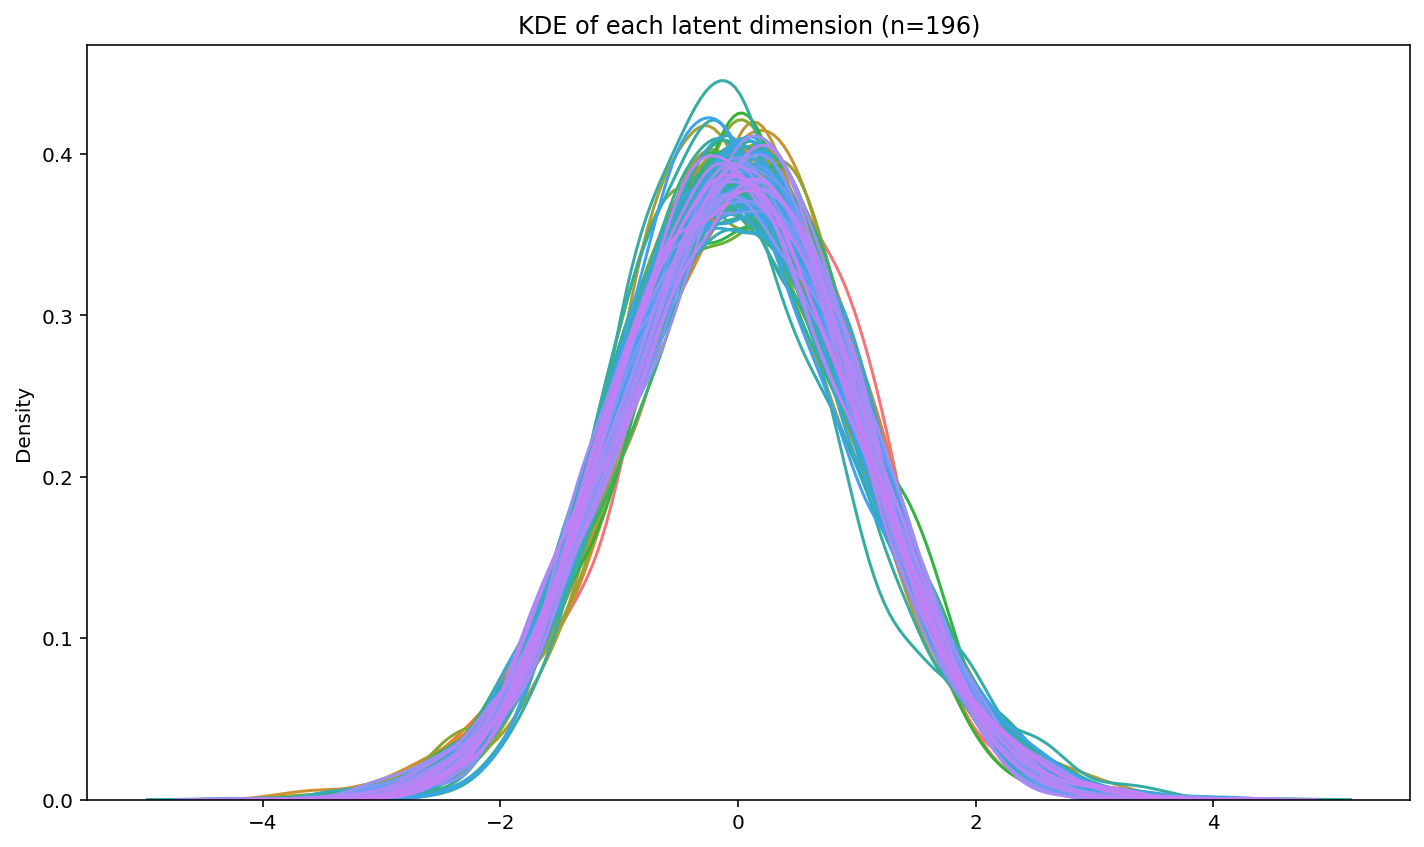

In [4]:
# encode 5000 random molecules and plot a kernel density estimate of their latent representation
# to show that the latent variables follow a gaussian distribution
# TODO: the paper encodes molecules from outside the training set

rand_5000_molecules = vae.random_molecules(size=5000)
X_rand_5000_molecules = vae.smiles_to_hot(rand_5000_molecules,canonize_smiles=True)
z_rand_5000_molecules = vae.encode(X_rand_5000_molecules)

# Set up the plotting environment
plt.figure(figsize=(10, 6))

# For each dimension in the data, compute and plot the KDE
for dim in range(z_rand_5000_molecules.shape[1]):
    sns.kdeplot(z_rand_5000_molecules[:, dim], legend=False, color=sns.color_palette("husl", 196)[dim])

plt.title('KDE of each latent dimension (n=196)')
#plt.xlabel('Z (unstandardized)')
#plt.ylabel('Normalized Frequency')
plt.tight_layout()
plt.show()

b) histogram of sampled
molecules for a single point in the latent space; the distances of the molecules from the original query are shown by the lines corresponding to the right axis


![](../aux_data/fig2b.PNG)

In [5]:
# no idea which molecule exactly they used for this plot
# it should be a "sample FDA-approved drug molecule"
# here I just picked a random one from the QM9 dataset
molecule = mu.canon_smiles("Cn1ccc(C=O)n1")
print(molecule)
X = vae.smiles_to_hot(molecule,canonize_smiles=True)
z = vae.encode(X)

decode_attempts = 100

Z = np.tile(z, (decode_attempts, 1))
X = vae.decode(Z)
smiles = vae.hot_to_smiles(X, strip=True)
df = vae.prep_mol_df(smiles, z)

print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])),sum(df['count'])))
print('SMILES\n',df.smiles)

Cn1ccc(C=O)n1
Found 6 unique mols, out of 80
SMILES
 0    Cn1ccc(C=O)n1
1    CNc1cc(C=O)n1
2    Cn1cnc(C=O)n1
3    Cn1ncc(C=O)n1
4    Cn1cnccc(O)n1
5    CN1cnc(C=O)n1
Name: smiles, dtype: object


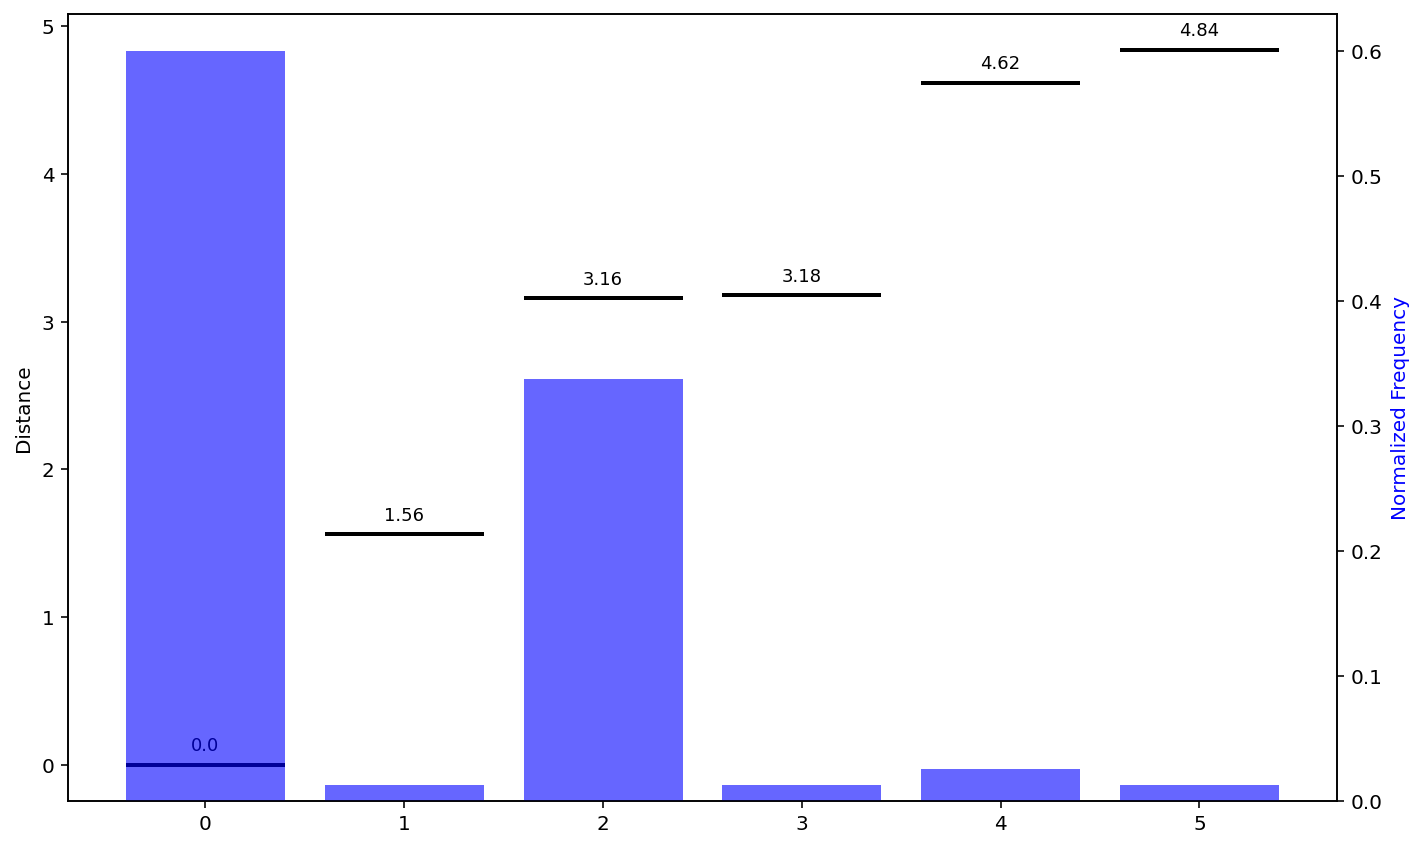

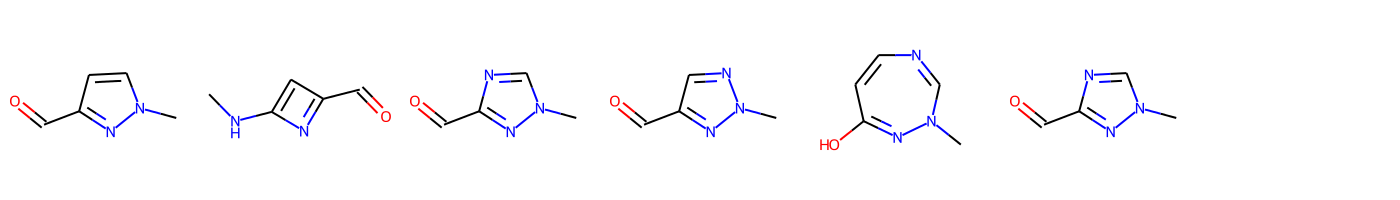

In [6]:
# Create a new figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create a secondary y-axis for the frequency bars
ax2 = ax1.twinx()

# Plot the bar chart using the frequency column on ax2
bars = ax2.bar(df.index, df['frequency'], alpha=0.6, label='Frequency', color='blue')

# Plot horizontal lines representing distance over each bar and annotate the distance value on ax1
for bar, distance in zip(bars, df['distance']):
    ax1.hlines(distance, bar.get_x(), bar.get_x() + bar.get_width(), colors='black', linewidth=2)
    
    # Round the distance value to 2 decimal places
    rounded_distance = round(distance, 2)
    
    # Annotate the rounded distance value
    ax1.annotate(str(rounded_distance),
                 (bar.get_x() + bar.get_width()/2, distance),
                 textcoords="offset points",
                 xytext=(0,5),  # 5 points vertical offset
                 ha='center',
                 va='bottom',
                 fontsize=9,
                 color='black')

# Set the y-axis labels
ax1.set_ylabel('Distance', color='black')
ax2.set_ylabel('Normalized Frequency', color='blue')

# Set the x-axis ticks
ax1.set_xticks(df.index)
ax1.set_xticklabels(df.index)

plt.tight_layout()
plt.show()

display(PandasTools.FrameToGridImage(df,column='mol' , molsPerRow=7))

c) molecules sampled near the location of ibuprofen in latent space. The values below the molecules are the distance in latent space from
the decoded molecule to ibuprofen

![](../aux_data/fig2c.PNG)

Searching molecules randomly sampled from 40.00 std (z-distance) from the point
Found 3 unique mols, out of 3
SMILES
 0    [CH]1[N]CC([NH])C(=O)[C@]1
1     [C]1[CH]C=C([N])C(=O)[C]1
2     [C]1[C](C=C[NH])C(=O)[C]1
Name: smiles, dtype: object


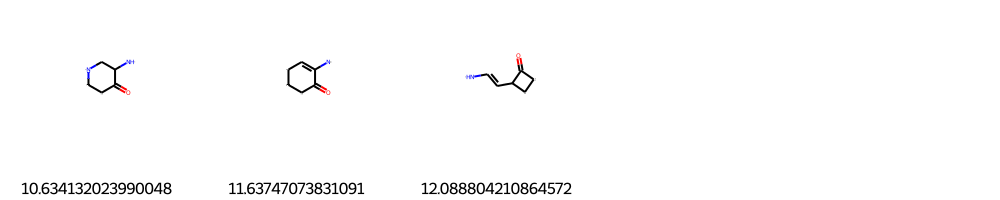

,smiles,distance,count,frequency,mol
0,[CH]1[N]CC([NH])C(=O)[C@]1,10.634132,1,0.333333,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,[C]1[CH]C=C([N])C(=O)[C]1,11.637471,1,0.333333,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,[C]1[C](C=C[NH])C(=O)[C]1,12.088804,1,0.333333,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [7]:
compound = pcp.get_compounds('Ibuprofen', 'name')[0]
smiles_1 = mu.canon_smiles(compound.isomeric_smiles)

X_1 = vae.smiles_to_hot(smiles_1,canonize_smiles=True)
z_1 = vae.encode(X_1)

noise=40.0
print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point'.format(noise))
df = vae.z_to_smiles(z_1, decode_attempts=2000,noise_norm=noise)
print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])),sum(df['count'])))
print('SMILES\n',df.smiles)
display(PandasTools.FrameToGridImage(df,column='mol', legendsCol='distance',molsPerRow=5))
df.head()

d) slerp interpolation between two molecules in latent space using six steps of equal distance

![](../aux_data/fig2d.PNG)

/home/sven/miniconda3/envs/chemvae/lib/python3.6/site-packages/scipy/spatial/_geometric_slerp.py:208: UserWarning: start and end are antipodes using the specified tolerance; this may cause ambiguous slerp paths
  warnings.warn("start and end are antipodes"


smiles                                                     CCO
distance                                               1.12497
count                                                      332
frequency                                             0.798077
mol          <img data-content="rdkit/molecule" src="data:i...
Name: 0, dtype: object
smiles                                                     O=O
distance                                               2.11947
count                                                        2
frequency                                           0.00574713
mol          <img data-content="rdkit/molecule" src="data:i...
Name: 0, dtype: object
smiles                                                     O=O
distance                                               2.66269
count                                                       10
frequency                                            0.0337838
mol          <img data-content="rdkit/molecule" src="data:i...
Name: 0, 

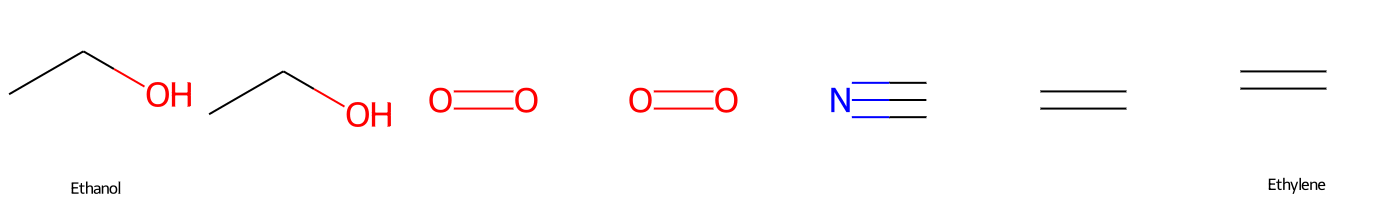

In [8]:
# prepare interpolation
methanol_compound = pcp.get_compounds('Ethanol', 'name')[0]
ammonia = pcp.get_compounds('Ethylene', 'name')[0]

smiles_ace = mu.canon_smiles(methanol_compound.isomeric_smiles)
smiles_pro = mu.canon_smiles(ammonia.isomeric_smiles)
molecule_smiles = [smiles_ace, smiles_pro]

slerp_df = pd.DataFrame({'smiles': molecule_smiles, "slerp": [0.0, 1.0], "name": ["Ethanol", "Ethylene"]})
slerp_df["mol"] = slerp_df['smiles'].apply(mu.smiles_to_mol)

X_mols = vae.smiles_to_hot(molecule_smiles,canonize_smiles=True)
z_mols = vae.encode(X_mols)

from scipy.spatial import geometric_slerp

for i in range(1, 6):
    fraction = i / 7.0

    decode_attempts = 500

    sphere_center = 0.5 * z_mols[0] + 0.5 * z_mols[1]

    start_mol_z = z_mols[0] - sphere_center
    end_mol_z = z_mols[1] - sphere_center

    norm_scale = np.linalg.norm(start_mol_z)
    assert np.linalg.norm(start_mol_z) - np.linalg.norm(end_mol_z) < 0.0001

    start_mol_z /= norm_scale
    end_mol_z /= norm_scale

    z_slerped = geometric_slerp(start_mol_z, end_mol_z, fraction)
    z_slerped = z_slerped * norm_scale + sphere_center

    Z = np.tile(z_slerped, (decode_attempts, 1))
    X = vae.decode(Z)
    smiles = vae.hot_to_smiles(X, strip=True)
    df = vae.prep_mol_df(smiles, z_slerped)
    if len(df) == 0:
        print(f"Could not decode a valid molecule after {decode_attempts} attempts.")
        continue
    clostest_mol = df.iloc[0]
    print(clostest_mol)
    slerp_df = slerp_df.append({"smiles": clostest_mol["smiles"], "slerp": fraction, "name": "", "mol": clostest_mol["mol"]}, ignore_index=True)

slerp_df = slerp_df.sort_values("slerp")
print(slerp_df)
    
display(PandasTools.FrameToGridImage(slerp_df,column='mol', legendsCol="name", molsPerRow=7))

### Figure 3: Representations of the sampling results from the variational autoencoder

![](../aux_data/fig3qm9.PNG)

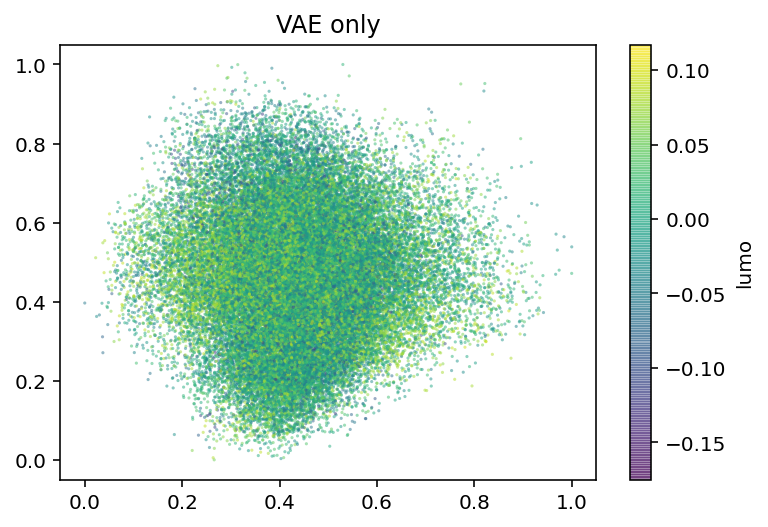

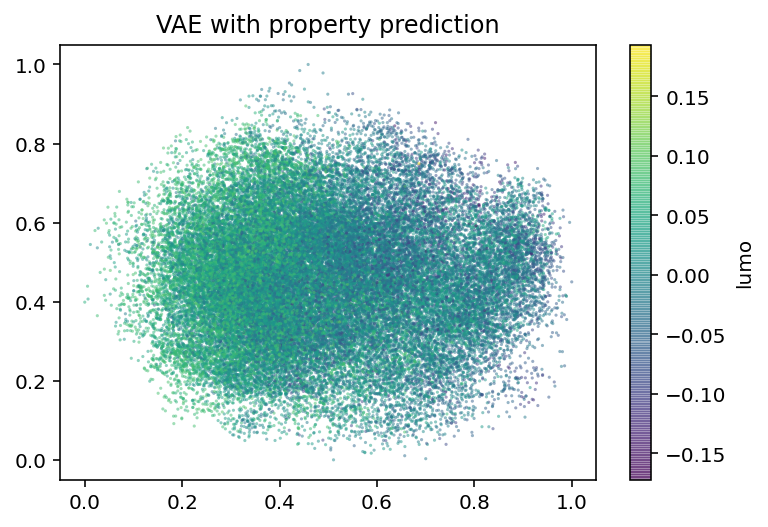

In [9]:
def pca_latent_vis(vae_model, prop_opt, title):
    Z, data, smiles = vae_model.ls_sampler_w_prop(size=50000,return_smiles=True)
    prop_df = pd.DataFrame(data).reset_index()
    prop_df['smiles']=smiles

    from sklearn.decomposition import PCA
    from sklearn.preprocessing import MinMaxScaler

    # do pca and normalize
    Z_pca = PCA(n_components=2).fit_transform(Z)
    Z_pca = MinMaxScaler().fit_transform(Z_pca)

    df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
    df.columns = ['x','y']
    df[prop_opt]=prop_df[prop_opt]

    scatter = plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
                cmap= 'viridis', marker='.',
                s=10,alpha=0.5, edgecolors='none')
    plt.colorbar(scatter, label=prop_opt)
    plt.title(title)
    plt.show()
    
pca_latent_vis(vae, "lumo", "VAE only")
pca_latent_vis(vae_properties, "lumo", "VAE with property prediction")

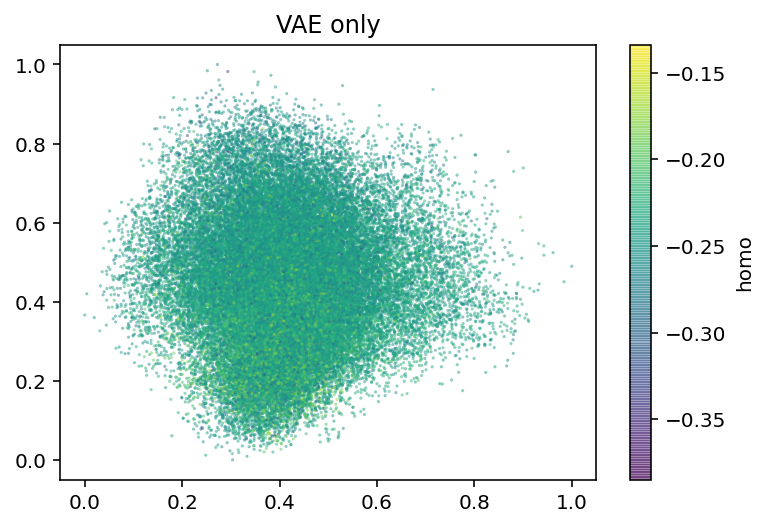

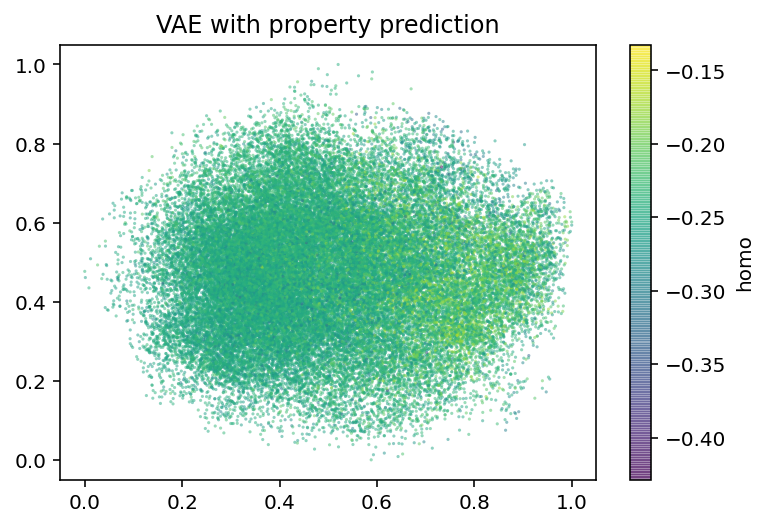

In [10]:
pca_latent_vis(vae, "homo", "VAE only")
pca_latent_vis(vae_properties, "homo", "VAE with property prediction")

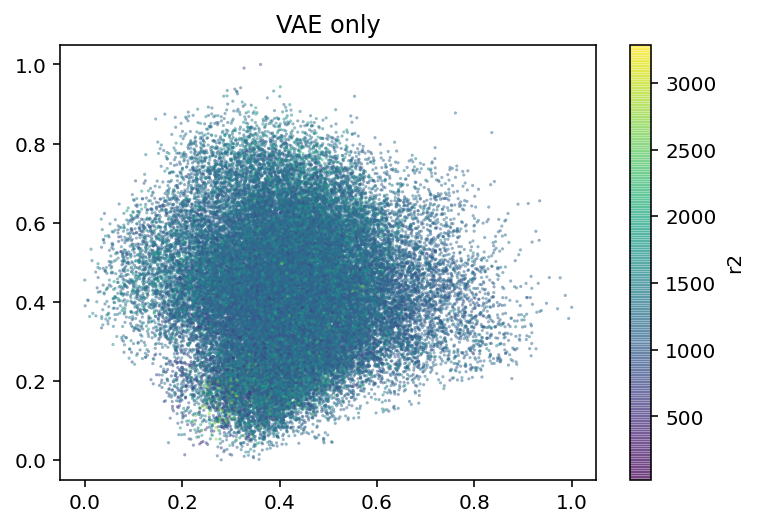

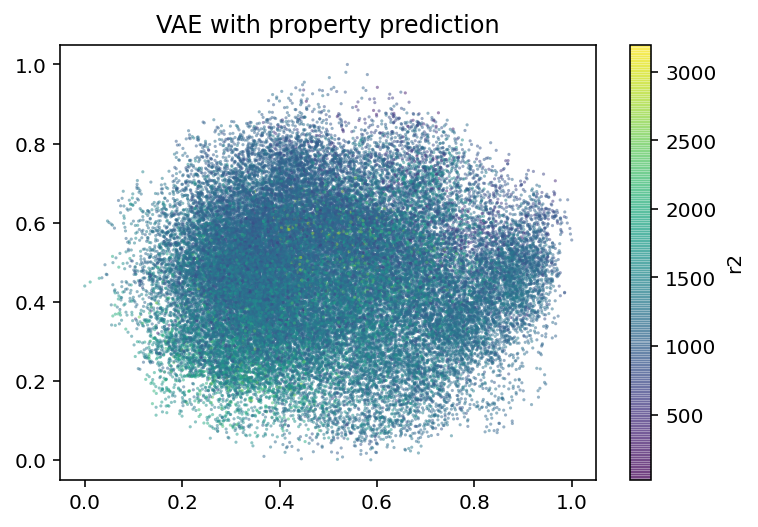

In [11]:
pca_latent_vis(vae, "r2", "VAE only")
pca_latent_vis(vae_properties, "r2", "VAE with property prediction")

### Table 1: Comparison of Molecule Generation Results to Original Datasets

![](../aux_data/tab1qm9.PNG)

In [12]:
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

# generate random by encoding 50 random molecules and decoding them 400 times
seed_size = 100

Z, _ = vae.ls_sampler_w_prop(size=seed_size)
generated_smiles = set()
for i in tqdm(range(Z.shape[0])):
    z = Z[i,:]
    decode_attempts = 400
    Z_tiled = np.tile(z, (decode_attempts, 1))
    X = vae.decode(Z_tiled)
    smiles = vae.hot_to_smiles(X, strip=True)
    df = vae.prep_mol_df(smiles, z)

    generated_smiles.update(df["smiles"])

100%|██████████| 100/100 [02:37<00:00,  1.58s/it]


In [14]:
# generate molecules by decoding random gaussian noise
Z = np.random.normal(0, 1, (400, 156))
generated_smiles_random = set()
for i in tqdm(range(Z.shape[0])):
    z = Z[i,:]
    decode_attempts = 100
    Z_tiled = np.tile(z, (decode_attempts, 1))
    X = vae.decode(Z_tiled)
    smiles = vae.hot_to_smiles(X, strip=True)
    df = vae.prep_mol_df(smiles, z)

    generated_smiles_random.update(df["smiles"])

100%|██████████| 400/400 [04:27<00:00,  1.50it/s]


In [15]:
# compute qed, logp and SAS for the whole dataset
dataset_smiles = vae.random_molecules()

logP_vals = []
qed_vals = []
sas_vals = []
for mol_smiles in tqdm(dataset_smiles):
    mol = Chem.MolFromSmiles(mol_smiles)
    logP_vals.append(Crippen.MolLogP(mol))
    try:
        qed_vals.append(QED.qed(mol))
    except:
        pass
    sas_vals.append(sascorer.calculateScore(mol))

print(f"QM9 samples = {len(dataset_smiles)}")
logP_np = np.array(logP_vals)
print(f"QM9 logP mean(std) = {logP_np.mean():.2f}({logP_np.std():.2f})")

sas_np = np.array(sas_vals)
print(f"QM9 SAS mean(std) = {sas_np.mean():.2f}({sas_np.std():.2f})")

qed_np = np.array(qed_vals)
print(f"QM9 QED mean(std) = {qed_np.mean():.2f}({qed_np.std():.2f})")
print("-------------------------------------")


# VAE (encode-decode) generated dataset property stats
logP_vals = []
qed_vals = []
sas_vals = []
for mol_smiles in tqdm(generated_smiles):
    mol = Chem.MolFromSmiles(mol_smiles)
    logP_vals.append(Crippen.MolLogP(mol))
    try:
        qed_vals.append(QED.qed(mol))
    except:
        pass
    sas_vals.append(sascorer.calculateScore(mol))

print(f"VAE (encode-decode) samples = {len(generated_smiles)}")
logP_np = np.array(logP_vals)
print(f"VAE (encode-decode) logP mean(std) = {logP_np.mean():.2f}({logP_np.std():.2f})")

sas_np = np.array(sas_vals)
print(f"VAE (encode-decode) SAS mean(std) = {sas_np.mean():.2f}({sas_np.std():.2f})")

qed_np = np.array(qed_vals)
print(f"VAE (encode-decode) QED mean(std) = {qed_np.mean():.2f}({qed_np.std():.2f})")
print("-------------------------------------")

# VAE (random) generated dataset property stats
logP_vals = []
qed_vals = []
sas_vals = []
for mol_smiles in tqdm(generated_smiles_random):
    mol = Chem.MolFromSmiles(mol_smiles)
    logP_vals.append(Crippen.MolLogP(mol))
    try:
        qed_vals.append(QED.qed(mol))
    except:
        pass
    sas_vals.append(sascorer.calculateScore(mol))

print(f"VAE (random) samples = {len(generated_smiles_random)}")
logP_np = np.array(logP_vals)
print(f"VAE (random) logP mean(std) = {logP_np.mean():.2f}({logP_np.std():.2f})")

sas_np = np.array(sas_vals)
print(f"VAE (random) SAS mean(std) = {sas_np.mean():.2f}({sas_np.std():.2f})")

qed_np = np.array(qed_vals)
print(f"VAE (random) QED mean(std) = {qed_np.mean():.2f}({qed_np.std():.2f})")

KeyboardInterrupt: 

### Table 2: MAE Prediction Error for Properties Using Various Methods on the ZINC and QM9 Datasets

![](../aux_data/tab2qm9.PNG)

In [ ]:
Z, data = vae_properties.ls_sampler_w_prop(size=50000)
prop_df = pd.DataFrame(data).reset_index()

# important detail :)
hartree_to_electronvolt_scale = 27.2114

y_homo_mean = prop_df['homo'].to_numpy().mean()
y_lumo_mean = prop_df['lumo'].to_numpy().mean()

print(f"homo Mean MAE (eV) = {(np.abs(y_homo_mean - prop_df['homo'].to_numpy())).mean() * hartree_to_electronvolt_scale}")
print(f"lumo Mean MAE (eV) = {(np.abs(y_lumo_mean - prop_df['lumo'].to_numpy())).mean() * hartree_to_electronvolt_scale}")

y_vae = vae_properties.predict_prop_Z(Z)
print(f"homo VAE MAE (eV) = {(np.abs(y_vae[:,0] - prop_df['homo'].to_numpy())).mean() * hartree_to_electronvolt_scale}")
print(f"lumo VAE MAE (eV) = {(np.abs(y_vae[:,1] - prop_df['lumo'].to_numpy())).mean() * hartree_to_electronvolt_scale}")

homo Mean MAE (eV) = 0.43962398554550264
lumo Mean MAE (eV) = 1.0346870991873454
homo VAE MAE = 0.31924115307182904
lumo VAE MAE = 0.4828384687648486


TODO: figure 4 (need to implement the gaussian process)